In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Nick\AppData\Local\Temp\ipykernel_21872\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [11]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


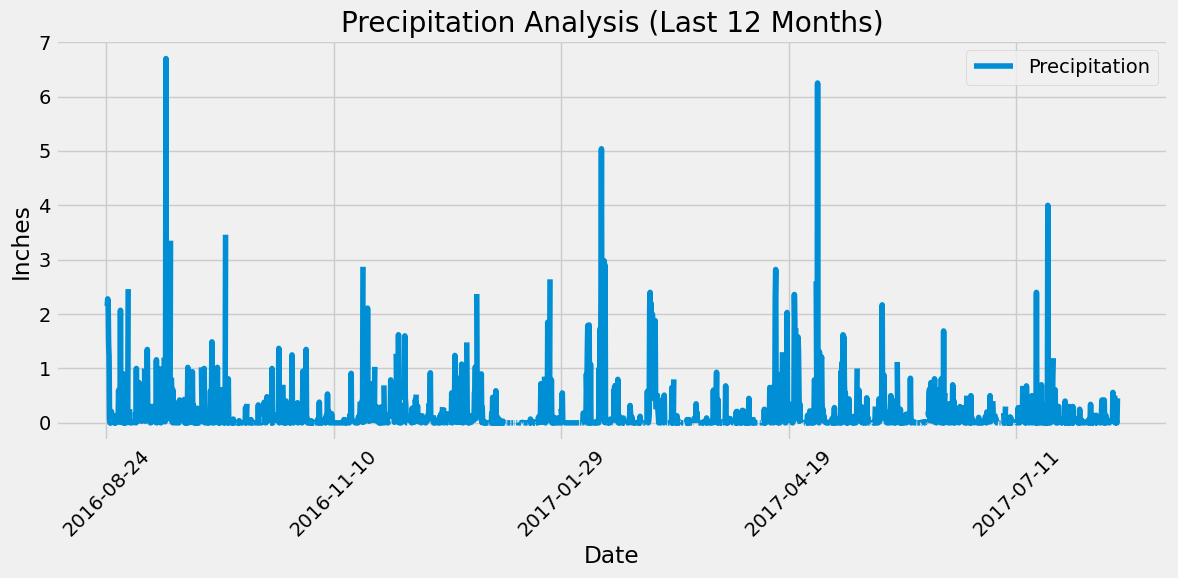

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Analysis (Last 12 Months)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f'Total number of stations in the dataset: {total_stations}')

Total number of stations in the dataset: 9


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station ID: {station}, Observation Count: {count}")

Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  # Retrieve the most active station ID
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

for result in temperature_stats:
    print(f"Most Active Station ID: {most_active_station}")
    print(f"Lowest Temperature: {result[0]} F")
    print(f"Highest Temperature: {result[1]} F")
    print(f"Average Temperature: {result[2]} F")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


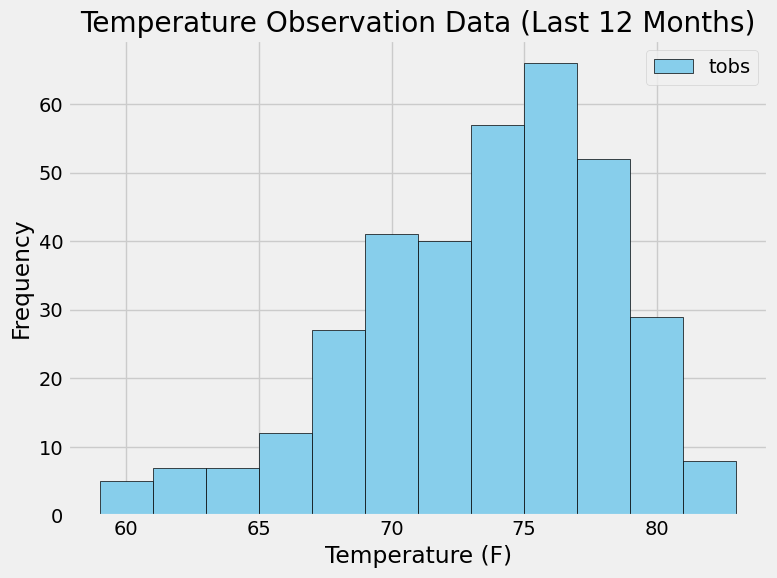

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
# Extract temperatures from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.legend(['tobs'], loc='best')
plt.tight_layout()
plt.show()

# Close Session

In [24]:
# Close Session
session.close()